In [ ]:
# https://github.com/jupyter-widgets/ipywidgets/issues/1744
from IPython.display import clear_output

# Fully local installation
# Step 1. Reinstall keras, https://github.com/matterport/Mask_RCNN/issues/694.
! pip install 'keras==2.1.6' --force-reinstall

# Step 2. Install TF1.
# ! pip install --upgrade --force-reinstall tensorflow==1.15.0
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

# Step 3. Install siamese-mask-rcnn
import os
os.chdir('/content')
! git clone https://github.com/bethgelab/siamese-mask-rcnn.git

# Step 3. Install proper version of pycocotools
! pip3 list | grep pycocotools
! pip3 uninstall pycocotools
! pip3 list | grep pycocotools
os.chdir('/content/siamese-mask-rcnn/data/')
! git clone https://github.com/waleedka/coco
# ! make >> outfile 2>&1
os.chdir('/content/siamese-mask-rcnn/data/coco/PythonAPI/')
! python3 setup.py build_ext install >> outfile 2>&1
! rm -rf build
! pip3 list | grep pycocotools

# Step 4. Download dataset and annotations
! mkdir -p /content/coco
os.chdir('/content/coco')
! wget http://images.cocodataset.org/zips/val2017.zip
! unzip -q val2017.zip  
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
! unzip -q annotations_trainval2017.zip

# Step 3.3. Add trained models
! mkdir -p /content/siamese-mask-rcnn/checkpoints
os.chdir('/content/siamese-mask-rcnn/checkpoints')
! wget https://github.com/bethgelab/siamese-mask-rcnn/releases/download/v0.1/small_siamese_mrcnn_0160.h5

# Step 3.4. Improve the numpy version
! pip3 install --force-reinstall numpy==1.16.0

clear_output()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# ! wget http://images.cocodataset.org/zips/train2017.zip
# ! wget http://images.cocodataset.org/zips/val2017.zip
# ! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# ! wget https://github.com/bethgelab/siamese-mask-rcnn/releases/download/v0.1/small_siamese_mrcnn_0160.h5

# Clone siamese-mask-rcnn
# ! git clone https://github.com/bethgelab/siamese-mask-rcnn.git
# Some packages will be incompatible with numpy=1.14.1  and imgaug=0.2.9
# ! pip list | grep -E -- 'numpy|Cython|scikit-image|keras|h5py|imgaug|opencv-python'
# ! sudo pip install numpy=1.14.1 cython scikit_image==0.13.1 keras==2.1.6 h5py imgaug opencv_python

# ! cp -r val2017 /content/coco/
# ! cp -r annotations/ /content/coco/

In [2]:
from IPython.display import clear_output

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
sess_config = tf.compat.v1.ConfigProto()

import sys
import os

COCO_DATA = '/content/coco'
os.chdir('/content/siamese-mask-rcnn')
MASK_RCNN_MODEL_PATH = 'lib/Mask_RCNN/'

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
    
from samples.coco import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
from lib import utils as siamese_utils
from lib import model as siamese_model
from lib import config as siamese_config
   
import time
import datetime
import random
import numpy as np
import skimage.io
import imgaug
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


1.15.2




Using TensorFlow backend.


In [3]:
# train_classes = coco_nopascal_classes
train_classes = np.array(range(1,81))

# Load COCO/val dataset
coco_val = siamese_utils.IndexedCocoDataset()
coco_object = coco_val.load_coco(COCO_DATA, "val", year="2017", return_coco=True)
coco_val.prepare()
coco_val.build_indices()
coco_val.ACTIVE_CLASSES = train_classes

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [ ]:
class SmallEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
class LargeEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
    # Large image sizes
    TARGET_MAX_DIM = 192
    TARGET_MIN_DIM = 150
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Large model size
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024
    FPN_FEATUREMAPS = 256
    # Large number of rois at all stages
    RPN_ANCHOR_STRIDE = 1
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 100
    MAX_GT_INSTANCES = 100

In [ ]:
# The small model trains on a single GPU and runs much faster.
# The large model is the same we used in our experiments but needs multiple GPUs and more time for training.
model_size = 'small' # or 'large'
if model_size == 'small':
    config = SmallEvalConfig()
elif model_size == 'large':
    config = LargeEvalConfig()
    
config.display()

# Provide training schedule of the model
# When evaluationg intermediate steps the tranining schedule must be provided
train_schedule = OrderedDict()
if model_size == 'small':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[120] = {"learning_rate": config.LEARNING_RATE, "layers": "4+"}
    train_schedule[160] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}
elif model_size == 'large':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[240] = {"learning_rate": config.LEARNING_RATE, "layers": "all"}
    train_schedule[320] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}

# Select checkpoint
if model_size == 'small':
    checkpoint = 'checkpoints/small_siamese_mrcnn_0160.h5'
elif model_size == 'large':
    checkpoint = 'checkpoints/large_siamese_mrcnn_coco_full_0320.h5'

clear_output()

In [6]:
# Load and evaluate model
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=train_schedule)
# Evaluate only active classes
active_class_idx = np.array(coco_val.ACTIVE_CLASSES) - 1

clear_output()
# Evaluate on the validation set
print('starting evaluation ...')
siamese_utils.evaluate_dataset(model, coco_val, coco_object, eval_type="bbox", 
                 dataset_type='coco', limit=1000, image_ids=None, 
                 class_index=active_class_idx, verbose=1)


starting evaluation ...
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.59s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

In [7]:
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=train_schedule)

loading checkpoints/small_siamese_mrcnn_0160.h5 ...
starting from epoch 160


image_id 4658
Processing 1 images
image                    shape: (612, 612, 3)         min:    0.00000  max:  255.00000  uint8
target                   shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  188.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.80000  max:  151.10000  float64
molded_targets           shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  188.00000  uint8
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


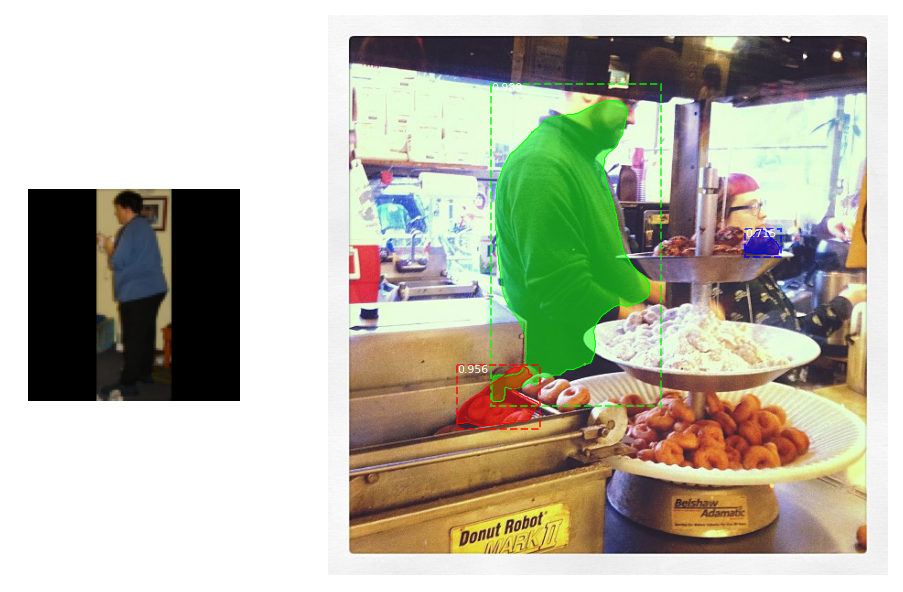

In [8]:
# Select category
category = 1
image_id = np.random.choice(coco_val.category_image_index[category])   
# Load target
target = siamese_utils.get_one_target(category, coco_val, config)
# Load image
image = coco_val.load_image(image_id)
print("image_id", image_id)


# Run detection
results = model.detect([[target]], [image], verbose=1)
r = results[0]
# Display results
siamese_utils.display_results(target, image, r['rois'], r['masks'], r['class_ids'], r['scores'])